### Figure 2: Cell Turnover, Anisomycin Effects, and Placefield Stability Remapping

Note that you must run through `run_placefields.py` for each mouse to check day-to-day alignment of behavioral data before running most of the place field related functions below.

In [284]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror, fix_xlabels
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import cell_tracking as ct
import er_plot_functions as erp
from helpers import flatten
from subjects import load_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up plots

In [2]:
Fig2comb, FigS4comb, FigS4bcomb, FigS4ccomb, Fig2insetcomb = None, None, None, None, None

In [185]:
# Set up main figure plotting
%matplotlib ipympl
Fig2 = Fig(num=2, grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(Fig2.fig.get_size_inches())

[6.375 4.875]


In [186]:
# Set up stats figure
Fig2stats = Fig(num="Figure 2 stats", grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(Fig2.fig.get_size_inches())
Fig2comb = FigMirror(Fig2, Fig2stats)

[6.375 4.875]


In [187]:
# Set up supplemental fig + stats
FigS4 = Fig(num="Figure S4", grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(FigS4.fig.get_size_inches())

[6.375 4.875]


In [188]:
FigS4stats = Fig(num="Figure S4 stats", grid=(4, 4), size=(6.375, 4.875), fontsize=6)
print(FigS4stats.fig.get_size_inches())
FigS4comb = FigMirror(FigS4, FigS4stats)

[6.375 4.875]


### Fig 2A-B: Cell turnover across days

In [7]:
# Test code for reshaping - want 1st index from 3rd dim folded into 2nd, e.g. combine shock v shock and open v open
# Not currently used, but could be useful if we need to add in "open" v "open" overlaps at some later point, no
# currently included, only "shock" v "shock"
a = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
a[:, :, 1] = a[:, :, 1]*10
print(a)
# So 1, 4, 7, and 20, 50, 80 are same arena, 3, 6, 9 are different
b = np.append(a, np.nan*np.ones_like(a[:, :, 2, None]), axis=2)
c = b.reshape((int(b.shape[0]*2), b.shape[1], int(b.shape[2]/2)), order='F')
print('3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80')
print(c[:, :, 0])
print('3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan')
print(c[:, :, 1])
# Ok, so this works - things are grouped appropriately

[[[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]

 [[ 1 20  3]
  [ 4 50  6]
  [ 7 80  9]]]
3rd dim index = 0 after reshaping - should be 1, 4, 7, 20, 50, 80
[[ 1.  7. 50.]
 [ 1.  7. 50.]
 [ 4. 20. 80.]
 [ 4. 20. 80.]]
3rd dim index = 1 after reshaping - should be 3, 6, 9, and nan
[[ 3.  9. nan]
 [ 3.  9. nan]
 [ 6. nan nan]
 [ 6. nan nan]]


0.2985781990521327


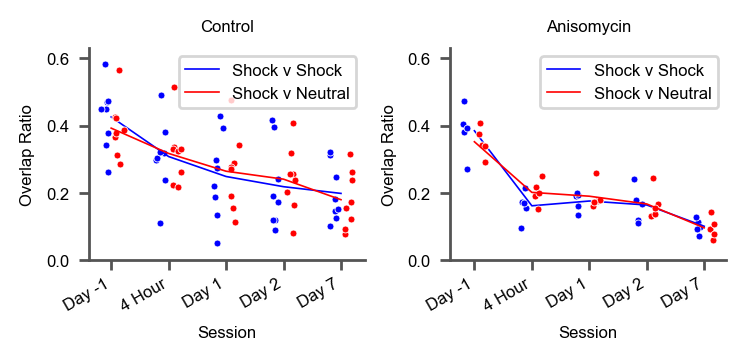

In [8]:
plot_ind = False
ylims = (0, 0.63)

axolap_ctrl = Fig2.subplot(441)
axolap_ani = Fig2.subplot(442)

oratioboth_comb = []
base_day = -2
for ax, mice, group_title in zip([axolap_ctrl, axolap_ani], [err.control_mice_good, err.ani_mice_good], 
                                 ["Control", "Anisomycin"]):
    # days = [-1, 0, 4, 1, 2]  # use this to look at change from day 0 to 4hr sesh (good in control arena only)
    days = [-1, 4, 1, 2, 7]  # legit way - use to look at change across all days with 10 min sessions
    arenas = [["Shock", "Shock"], ["Shock", "Open"]]
    oratio1 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratio2 = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratioboth = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomin = np.ones((len(mice), len(days), len(arenas)))*np.nan
    oratiomax = np.ones((len(mice), len(days), len(arenas)))*np.nan

    # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    pathname = err.pathname  # Get plotting folder
    for idm, mouse in enumerate(mice):
        for idd, day in enumerate(days):
            for ida, arena_pair in enumerate(arenas):
                try:
                    _, _, oratioboth[idm, idd, ida], oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
                        pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
                    if (mouse == "Marble14") and (arena_pair[1] == "Shock") and (day == 4):
                        _, _, a, _, _ = \
                        pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
                        print(a)
                except TypeError:
                    print('Missing reg file for ' + mouse + ' Day ' + str(day) + ' ' + arena)

        if plot_ind:
            fig, ax, hline = er.plot_overlaps(oratio1[idm, :, :], days=days, size=4, linewidth=0.2, edgecolor='w')
            fig.savefig(os.path.join(pathname, 'Cell Overlap ' + group_title + '-' + mouse + '.pdf'))
            plt.close(fig)
    
    _, _ = er.plot_overlaps(oratioboth, days=days, jitter=[-0.09, 0.09], colors = ['b', 'r'], offset=(-0.14, 0.14),
                            arenas=['Shock v Shock', 'Shock v Neutral'], ax=ax, markersize=2.5,
                            meanlinewidth=0.6, markeredgecolor='w', markeredgewidth=0.3)
    ax.set_title(group_title)
    ax.set_ylabel('Overlap Ratio')
    ax.set_ylim(ylims)
    fix_xlabels(ax, rotate=True)

    oratioboth_comb.append(oratioboth)  # Create list with both groups data in it
Fig2.fig

#### Per KD analysis suggestion make the above plot but use 4 hour session as baseline. Not informative

In [ ]:
# plot_ind = False

# fig4, ax4 = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
# axolap4_ctrl = ax4[0]
# axolap4_ani = ax4[1]

# oratioboth_comb = []
# base_day = 4
# # days = [-1, 0, 4, 1, 2]  # use this to look at change from day 0 to 4hr sesh (good in control arena only)
# days = [-2, -1, 4, 1, 2, 7]  # legit way - use to look at change across all days with 10 min sessions
# for ax, mice, group_title in zip([axolap4_ctrl, axolap4_ani], [err.control_mice_good, err.ani_mice_good], 
#                                  ["Control", "Anisomycin"]):
#     days_use = [day for day in days if day != base_day]
#     arenas = [["Shock", "Shock"], ["Shock", "Open"]]
#     oratio1 = np.ones((len(mice), len(days), len(arenas)))*np.nan
#     oratio2 = np.ones((len(mice), len(days), len(arenas)))*np.nan
#     oratioboth = np.ones((len(mice), len(days), len(arenas)))*np.nan
#     oratiomin = np.ones((len(mice), len(days), len(arenas)))*np.nan
#     oratiomax = np.ones((len(mice), len(days), len(arenas)))*np.nan

#     # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
#     pathname = err.pathname  # Get plotting folder
#     for idm, mouse in enumerate(mice):
#         for idd, day in enumerate(days_use):
#             for ida, arena_pair in enumerate(arenas):
#                 try:
#                     _, _, oratioboth[idm, idd, ida], oratiomin[idm, idd, ida], oratiomax[idm, idd, ida] = \
#                         pfs.get_overlap(mouse, arena_pair[0], base_day, arena_pair[1], day)
#                 except TypeError:
#                     print('Missing reg file for ' + mouse + ' Day ' + str(day) + ' ' + arena)

#         if plot_ind:
#             fig, ax, hline = er.plot_overlaps(oratio1[idm, :, :], days=days)
#             fig.savefig(os.path.join(pathname, 'Cell Overlap ' + group_title + '-' + mouse + '.pdf'))
#             plt.close(fig)
    
#     _, _ = er.plot_overlaps(oratioboth, days=days, jitter=[-0.05, 0.05], colors = ['b', 'r'], 
#                               arenas=['Shock v Shock', 'Shock v Neutral'], ax=ax, markersize=2.0)
#     ax.set_title(group_title)
#     ax.set_ylabel('Overlap Ratio')

#     oratioboth_comb.append(oratioboth)  # Create list with both groups data in it.

### 2C Now quantify accelerated change and then slower change (measured by cell overlap) due to ANI administration

In [9]:
# Dump data into dataframe for easy plotting in seaborn afterward...
day_pairs = ['-1_4', '4_1', '1_2', '2_7']
grp_list, dolap_list, day_list = [], [], []
grp_mean_list, dolap_mean_list, day_mean_list = [], [], []
for idg, grp in enumerate(['Ctrl', 'ANI']):
    oratio_use = oratioboth_comb[idg]
    for idd, day_pair in enumerate(day_pairs):
        dolap = oratio_use[:, idd, :].reshape(-1) - oratio_use[:, idd + 1, :].reshape(-1)
        dolap_list.extend(dolap)
        grp_list.extend(len(dolap)*[grp])
        day_list.extend(len(dolap)*[day_pair])

        dolap_mean = (oratio_use[:, idd, :] - oratio_use[:, idd + 1, :]).mean(axis=1)
        dolap_mean_list.extend(dolap_mean)
        grp_mean_list.extend(len(dolap_mean)*[grp])
        day_mean_list.extend(len(dolap_mean)*[day_pair])

dolap_df = pd.DataFrame({'day_pair': day_list, 'dolap': dolap_list, 'Group': grp_list})
dolap_mean_df = pd.DataFrame({'day_pair': day_mean_list, 'dolap': dolap_mean_list, 'Group': grp_mean_list})

In [10]:
### Plot means
axolap_bw, axolap_bw_stats = Fig2comb.subplot(443)
# Adjust pallete to match color scheme in other plots
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
pal_use = pal_use[0:2]
hdolap = sns.stripplot(data=dolap_mean_df, x='day_pair', y='dolap', hue='Group', dodge=True, palette=pal_use, 
                       ax=axolap_bw, size=2.5, linewidth=0.3, edgecolor='w', jitter=0.15)
# Fix legend markers
for h1 in hdolap.legend().legend_handles:
    h1._sizes = [3]
axolap_bw.set_ylabel(r'$\Delta_{overlap}$')
axolap_bw.set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])
axolap_bw.set_xlabel('Day Pair')

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_26255/3543242998.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axolap_bw.set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])


Text(0.5, 0, 'Day Pair')

In [11]:
ytext = 0.7
axolap_bw_stats.text(0.1, 0.8, r'Delta overlap bw groups stats}')
for day_pair in set(dolap_mean_df['day_pair']):
    ctrl = dolap_mean_df[(dolap_mean_df['Group'] == 'Ctrl') & (dolap_mean_df['day_pair'] == day_pair)]['dolap']
    ani = dolap_mean_df[(dolap_mean_df['Group'] == 'ANI') & (dolap_mean_df['day_pair'] == day_pair)]['dolap']
    tstat, pval = sstats.ttest_ind(ctrl, ani, nan_policy='omit', alternative="two-sided")
    print(f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    axolap_bw_stats.text(0.1, ytext, f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ytext -= 0.1

day pair 1_2: pval=0.705 with tstat=0.388
day pair -1_4: pval=0.00174 with tstat=-4.11
day pair 4_1: pval=0.115 with tstat=1.71
day pair 2_7: pval=0.315 with tstat=-1.05


/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_26255/1453367437.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])


Text(0.5, 0, 'Day Pair')

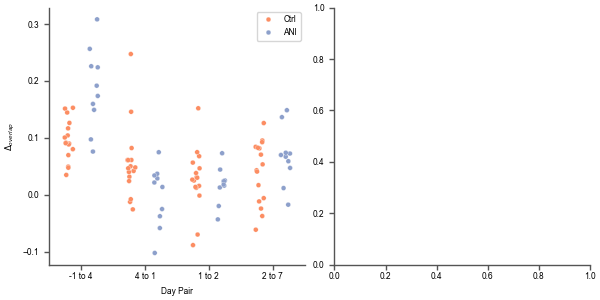

In [12]:
# Plot all data points individually for reference
_, ax = plt.subplots(1, 2, figsize=(6, 3))

# Adjust pallete to match color scheme in other plots
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
pal_use = pal_use[0:2]
hdolap = sns.stripplot(data=dolap_df, x='day_pair', y='dolap', hue='Group', dodge=True, palette=pal_use, 
                       ax=ax[0], size=3.5, linewidth=0.2, edgecolor='w', jitter=0.15)
# Fix legend markers
for h1 in hdolap.legend().legend_handles:
    h1._sizes = [3]
ax[0].set_ylabel(r'$\Delta_{overlap}$')
ax[0].set_xticklabels([' to '.join(day_pair.split('_')) for day_pair in day_pairs])
ax[0].set_xlabel('Day Pair')

In [13]:
ytext = 0.7
ax[1].text(0.1, 0.8, r'Delta overlap bw groups stats}')
for day_pair in set(dolap_df['day_pair']):
    ctrl = dolap_df[(dolap_df['Group'] == 'Ctrl') & (dolap_df['day_pair'] == day_pair)]['dolap']
    ani = dolap_df[(dolap_df['Group'] == 'ANI') & (dolap_df['day_pair'] == day_pair)]['dolap']
    tstat, pval = sstats.ttest_ind(ctrl, ani, nan_policy='omit')
    print(f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ax[1].text(0.1, ytext, f'day pair {day_pair}: pval={pval:0.3g} with tstat={tstat:0.3g}')
    ytext -= 0.1

day pair 1_2: pval=0.624 with tstat=0.496
day pair -1_4: pval=0.000244 with tstat=-4.3
day pair 4_1: pval=0.028 with tstat=2.34
day pair 2_7: pval=0.229 with tstat=-1.24


### 2D Plot Number of Neurons active for each session

In [14]:
def nneurons_to_df(nneurons, arenas, days, mice, gname, norm_sesh_ind=0):
    """Put nneurons array into a dataframe for easy statistical analysis"""
    nmice, narenas, ndays = nneurons.shape
    assert nmice == len(mice)
    assert narenas == len(arenas)
    assert ndays == len(days)
    
    mouse_mat = np.matlib.repmat(mice, ndays, 1).T
    days_mat = np.matlib.repmat(days, nmice, 1)
    cond = []
    for day in days:
        if day in [-2, -1]:
            cond.append('Before')
        elif day == 4:
            cond.append('During')
        elif day in [1, 2, 7]:
            cond.append('After')
    cond_mat = np.matlib.repmat(cond, nmice, 1)
    df_list = []
    for ida, arena in enumerate(arenas):
        arena_mat = np.matlib.repmat([arena,]*ndays, nmice, 1)
        nneurons_norm = None
        if norm_sesh_ind is not None:
            nneurons_norm = ct.norm_num_neurons(nneurons[:, ida, :][:, None, :], norm_sesh_ind)
        df_list.append(pd.DataFrame({"nneurons" : nneurons[:, ida, :].reshape(-1), "nneurons_norm" : nneurons_norm.reshape(-1),
                                     "arena" : arena_mat.reshape(-1), "mouse" : mouse_mat.reshape(-1), 
                                     "day" : days_mat.reshape(-1), "condition" : cond_mat.reshape(-1), "Group" : (gname,)*cond_mat.size}))

    return pd.concat(df_list)

days = [-2, -1, 4, 1, 2, 7]
arenas = ['Shock', 'Open']
mice = err.ani_mice_good
nneurons = ct.get_group_num_neurons(mice, days=days, arenas=arenas)
nneurons_to_df(nneurons, arenas, days, mice, "ANI", 1).head(10)                               
        

,nneurons,nneurons_norm,arena,mouse,day,condition,Group
0,827.0,0.944064,Shock,Marble17,-2,Before,ANI
1,876.0,1.000000,Shock,Marble17,-1,Before,ANI
2,693.0,0.791096,Shock,Marble17,4,During,ANI
3,726.0,0.828767,Shock,Marble17,1,After,ANI
4,717.0,0.818493,Shock,Marble17,2,After,ANI
5,683.0,0.779680,Shock,Marble17,7,After,ANI
6,162.0,1.006211,Shock,Marble18,-2,Before,ANI
7,161.0,1.000000,Shock,Marble18,-1,Before,ANI
8,94.0,0.583851,Shock,Marble18,4,During,ANI
9,127.0,0.788820,Shock,Marble18,1,After,ANI


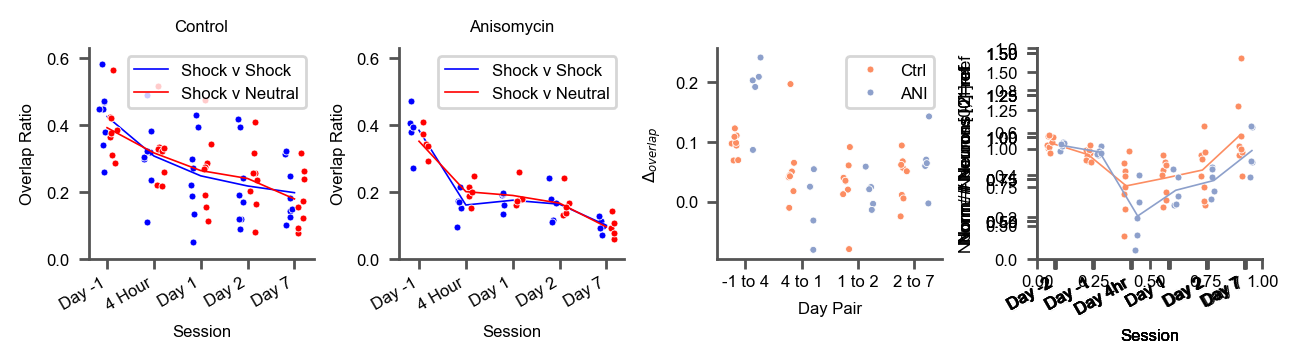

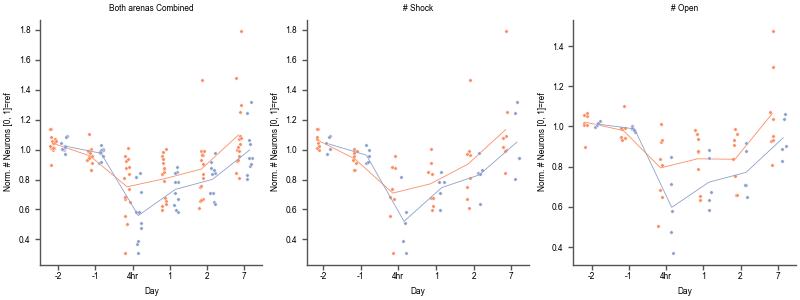

In [92]:
# Aggregate #neurons and plot each

days = [-2, -1, 4, 1, 2, 7]
norm_sesh_ind = [0, 1] # index of session from days array to normalize to

arenas = ['Shock', 'Open']
nneurons_comb, nneurons_mean_comb, nneurons_open_comb, nneurons_shock_comb = [], [], [], []
df_list, df_mean_list = [], []
for mice, grp in zip([err.control_mice_good, err.ani_mice_good], ["Control", "ANI"]):

    # # Get overlapping cell ratios for each day/arena using Shock day -2 as a reference
    nneurons = ct.get_group_num_neurons(mice, days=days, arenas=arenas)
    df_list.append(nneurons_to_df(nneurons, arenas, days, mice, grp, norm_sesh_ind))
    df_mean_list.append(nneurons_to_df(nneurons.mean(axis=1)[:, None, :], ['Combined'], days, mice, grp, norm_sesh_ind))
    nanimals = nneurons.shape[0]
    nneurons_comb.append(nneurons.reshape(int(2*nanimals), 1, len(days)))  # Combine both areas for each mouse
    nneurons_mean_comb.append(nneurons.mean(axis=1)[:, None, :])
    nneurons_shock_comb.append(nneurons[:, 0, :][:, None, :])
    nneurons_open_comb.append(nneurons[:, 1, :][:, None, :])

nneuron_df = pd.concat(df_list)
nneuron_mean_df = pd.concat(df_mean_list)

# Now plot - Total #s (un-normalized) plotted in supplemental
ax_nn_comb, ax_nn_comb_stats = Fig2comb.subplot(444)
_, ax_nn_mean_comb = plt.subplots(1, 3, figsize=(8, 3))
pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
pal_use.pop(0)
for nn, nn_mean, nn_shock, nn_open, color, offset in zip(nneurons_comb, nneurons_mean_comb, nneurons_shock_comb, nneurons_open_comb, 
                                                           pal_use[0:2], (-0.15, 0.15)):
    ct.plot_num_neurons(nn, arena1='Combined', arena2=None, normalize=['-2', '-1'], colors=[color], offset=offset, jitter=0.075,
                        markersize=2.5, ax=ax_nn_mean_comb[0], markeredgecolor='w', markeredgewidth=0.3, linewidth=0.6)
    ct.plot_num_neurons(nn_mean, arena1='Combined', arena2=None, normalize=['-2', '-1'], colors=[color], offset=offset, jitter=0.075,
                        markersize=2.5, ax=ax_nn_comb, markeredgecolor='w', markeredgewidth=0.3, linewidth=0.6)
    ct.plot_num_neurons(nn_shock, arena1='Combined', arena2=None, normalize=['-2', '-1'], colors=[color], offset=offset, jitter=0.075,
                        markersize=2.5, ax=ax_nn_mean_comb[1], markeredgecolor='w', markeredgewidth=0.3, linewidth=0.6)
    ct.plot_num_neurons(nn_open, arena1='Combined', arena2=None, normalize=['-2', '-1'], colors=[color], offset=offset, jitter=0.075,
                        markersize=2.5, ax=ax_nn_mean_comb[2], markeredgecolor='w', markeredgewidth=0.3, linewidth=0.6)
ax_nn_mean_comb[0].set_title('Both arenas Combined')
ax_nn_mean_comb[1].set_title('# Shock')
ax_nn_mean_comb[2].set_title('# Open')

fix_xlabels(ax_nn_comb, rotate=True)
Fig2.fig

In [60]:
# Stats for mean # neurons
nneurons_norm = [ct.norm_num_neurons(nn, [0, 1]) for nn in nneurons_mean_comb]
ax_nn_comb_stats.text(0.1, 0.8, 'Between group norm. # neurons stats')
ytext = 0.7
for idd, day in enumerate(days):
    # Separate data points for each arena
    n_ctrl = nneurons_norm[0][:, :, idd].reshape(-1)
    n_ani = nneurons_norm[1][:, :, idd].reshape(-1)
    tstat, pval = sstats.ttest_ind(n_ctrl, n_ani)
    print(f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ax_nn_comb_stats.text(0.1, ytext, f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ytext -= 0.1
    

Session -2: pval=0.429, tstat=0.822
Session -1: pval=0.429, tstat=-0.822
Session 4: pval=0.0845, tstat=1.9
Session 1: pval=0.272, tstat=1.16
Session 2: pval=0.443, tstat=0.795
Session 7: pval=0.408, tstat=0.861


In [18]:
# stats for all neurons combined
nneurons_norm = [ct.norm_num_neurons(nn, 0) for nn in nneurons_comb]
# ax_nn_comb_stats.text(0.1, 0.8, 'Between group norm. # neurons stats')
ytext = 0.7
for idd, day in enumerate(days):
    # Separate data points for each arena
    n_ctrl = nneurons_norm[0][:, :, idd].reshape(-1)
    n_ani = nneurons_norm[1][:, :, idd].reshape(-1)
    tstat, pval = sstats.ttest_ind(n_ctrl, n_ani)
    print(f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    # ax_nn_comb_stats.text(0.1, ytext, f'Session {day}: pval={pval:0.3g}, tstat={tstat:0.3g}')
    ytext -= 0.1
    

Session -2: pval=nan, tstat=nan
Session -1: pval=0.468, tstat=-0.737
Session 4: pval=0.0391, tstat=2.18
Session 1: pval=0.314, tstat=1.03
Session 2: pval=0.43, tstat=0.803
Session 7: pval=0.306, tstat=1.05


Run GLM to ensure that other covariates, which could influence the number of cells recorded, don't explain the lack of significance found during the 4 hour session or on days 1, 2 or 7.
Factors:
1) Arena: locomotion is different on bars in shock arena vs. sold floor in open/neutral arena
2) Before/During/After anisomyin/fear conditioning: Before assesses baseline # cells, During tests acute effect of ANI/fear conditioning on cell #s, and After assesses if there are any lasting effects of ANI (or Trace FC) on cells
3) Group: ANI vs. Ctrl
4) Freeze Ratio: it is well established that the number of place cells correlates with how much the animals moves / explores an arena.  Need to account for differences in locomotion between groups.
5) Interactions between Group and Before/During/After: assess if ANI has a differential effect at each time point.

In [19]:
import freezing_analysis as fa
def add_freezing(row, **kwargs):
    try:
        return fa.get_freeze_ratio(row['mouse'], row['arena'], row['day'], **kwargs)
    except FileNotFoundError:
        return np.nan

In [83]:
# Add in freezing ratio to dataframe
from copy import copy, deepcopy
nneuron_df2 = deepcopy(nneuron_df)
nneuron_df2["freeze_ratio"] = nneuron_df2.apply(add_freezing, axis=1)

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6


In [98]:
import statsmodels.api as sm
nneuron_df3 = nneuron_df2[~np.isnan(nneuron_df2.freeze_ratio)]
# nneuron_df3 = nneuron_df3[nneuron_df3.day != -2]
endog = nneuron_df3.nneurons_norm.values
intercept = np.ones(nneuron_df3.shape[0])
arena_array = [0 if arena == "Shock" else 1 for arena in nneuron_df3.arena]
bef_array = nneuron_df3.condition == "Before"
dur_array = nneuron_df3.condition == "During"
aft_array = nneuron_df3.condition == "After"
group_array = nneuron_df3.Group == "ANI"
group_by_before = group_array & bef_array
group_by_during = group_array & dur_array
group_by_after = group_array & aft_array
freeze_array = nneuron_df3.freeze_ratio.values
exog = np.array([intercept, arena_array, dur_array, aft_array, group_array, group_by_during, group_by_after, freeze_array]).T
exog_df = pd.DataFrame(data=exog, columns = ["Int", "Arena", "During", "After", "Group", "Group x During", "Group x After", "Freeze Ratio"])
model = sm.GLM(endog, exog_df)
model_results = model.fit()
print(model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  150
Model:                            GLM   Df Residuals:                      142
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                        0.028095
Method:                          IRLS   Log-Likelihood:                 59.183
Date:                Wed, 06 Mar 2024   Deviance:                       3.9894
Time:                        11:45:30   Pearson chi2:                     3.99
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4678
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Int                1.0742      0.037     29.

In [99]:
model_results.pvalues

Int               1.251887e-186
Arena              3.544571e-01
During             3.543007e-03
After              6.709533e-01
Group              9.849537e-01
Group x During     5.619660e-02
Group x After      9.398959e-02
Freeze Ratio       2.295355e-05
dtype: float64

#### Plot #6: Plot of off cells by quartile - plotted separately by Dan Orlin in MATLAB
Not used

In [ ]:
# Put in placeholder
ax_onoff = Fig2comb.subplot(445)
ax_onoff[0].text(0.1, 0.5, 'Placeholder for DO on/off by quartile plot')

Plot #6a (Supplemental 1): Example max projections showing washout in ANI recordings - include with more raw data from other animals.

### 2E-F: Example place-fields across sessions  

Marble07, Shock Day -2 to Day -1 gives neuron #27 has a good example neuron. Grab a few others maybe? Example of remapping neuron?

In [ ]:
gs_pf_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[2,0], grid=(2,2))
axp = []
for i in range(2):
    for j in range(2):
        axp.append(Fig2.fig.add_subplot(gs_pf_subfig[i, j]))
axp = np.array(axp).reshape(2,2)
PFS1 = pfs.PFCombineObject('Marble07', 'Shock', -2, 'Shock', -1)
nneuron = 27
PFS1.pfplot(nneuron, ax=axp, linewidth=0.5, markersize=1.0)

In [ ]:
Fig2.fig

In [ ]:
gs_pf_subfig2 = Fig2.subplot2grid(subplot_spec=Fig2.gs[1,0], grid=(2,2))
axp2 = []
for i in range(2):
    for j in range(2):
        axp2.append(Fig2.fig.add_subplot(gs_pf_subfig2[i, j]))
axp2 = np.array(axp2).reshape(2,2)
PFS1 = pfs.PFCombineObject('Marble07', 'Shock', -2, 'Shock', 1)
nneuron = 64
PFS1.pfplot(nneuron, ax=axp2, linewidth=0.5, markersize=1.0)

### Plot #7a (Supplemental 2): Example place fields from Learner, Non-Learner, and ANI. Plot by quartile - two from each maybe?

### Plots #8: Placefield stability and reorganization across days - ANI reduces shock-induced PF remapping and also stifles extinction-related remapping.  

Used for initial visualization only - move elsewhere

Missing pf files for Marble06 Shock Day -2 to Shock Day 7
Missing pf files for Marble06 Shock Day -1 to Shock Day 7
Missing pf files for Marble06 Shock Day 4 to Shock Day 7
Missing pf files for Marble06 Shock Day 1 to Shock Day 7
Missing pf files for Marble06 Shock Day 2 to Shock Day 7


FileNotFoundError: [Errno 2] No such file or directory: '/Users/nkinsky/Dropbox/Imaging Project/Manuscripts/Eraser/Figures/PFcorrs Shock v Shock Combined (green=Ani)group_desig2best_rotFalse.pdf'

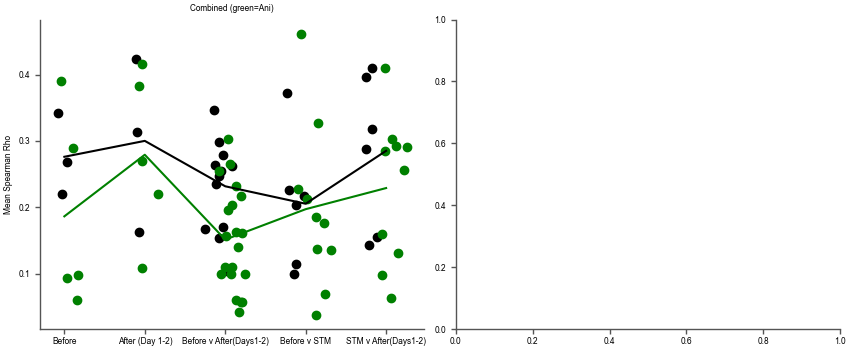

In [100]:
# # Scatterplot for each group independently
# group_desig = 2  # 1 = include days 1,2, AND 7 in after shock group, 2 = include days 1 and 2 only

# figc, axc = plt.subplots(1,2)
# figc.set_size_inches((8.5, 3.5))
# for arena, a in zip(['Shock', 'Open'], axc):
#     _, cont_corr_sm_mean_all, _, _ = pfs.get_group_pf_corrs(err.nonlearners, arena, arena, days, 
#                                                             batch_map_use=True, print_to_screen=False)
#     _, ani_corr_sm_mean_all, _, _ = pfs.get_group_pf_corrs(err.ani_mice_good, arena, arena, days, 
#                                                            batch_map_use=True, print_to_screen=False)

#     # Combined scatterplot
#     pfs.plot_pfcorr_bygroup(cont_corr_sm_mean_all, arena, arena, '', ax_use=a,
#                             color='k', offset=-0.1, save_fig=False, group_desig=group_desig)
#     pfs.plot_pfcorr_bygroup(ani_corr_sm_mean_all, arena, arena, 'Combined (green=Ani)',
#                         color='g', offset=0.1, ax_use=a, group_desig=group_desig, best_rot=False)

No placefields file found for Marble06 Open day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Open day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Open day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Open day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found for Marble06 Open day 7: creating PV1 from neural data only - NO SPEED THRESHOLDING


FileNotFoundError: [Errno 2] No such file or directory: '/Users/nkinsky/Dropbox/Imaging Project/Manuscripts/Eraser/Figures/PV1dcorrs_both Open v Open PV1dcorrs_both OpenvOpen Combined (k=learn, b=n-learn, g=Ani) best_rot=Truegroup_desig2best_rotTrue.pdf'

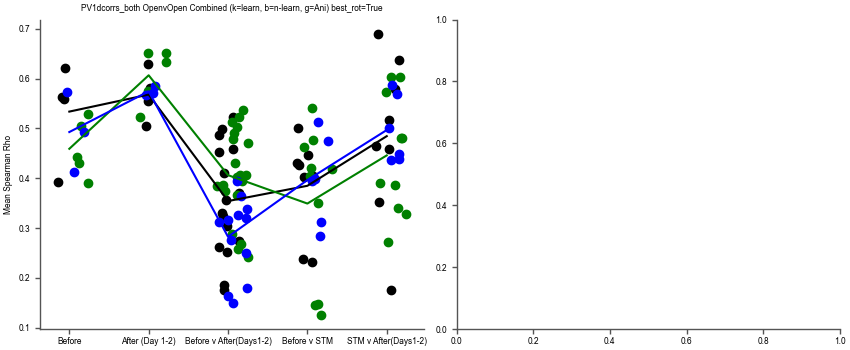

In [101]:
# def assemble_mean_corrs_all(corr_type: str in ['PF', 'PV1dboth', 'PV1all'], best_rot: bool, group_desig: int in [1, 2],
#                        plot=False, nshuf=0):
#     """Assemble pre-run MEAN place-field or MEAN population-vector correlations.
#     :param corr_type: 2d PFs, 1d pv including only cells active in both sessions or all sessions
#     :param best_rot: only applies to 2d PFs. True = rotate map to best rotation
#     :param group_desig: 1 = include day 7 in "After" comparisons, 2 = only include days 1-2 (before more extinction happens)
#     """
#     # Need to run this to set up plots - I'm sure there is a better way...one option is to write code to assemble
#     # these values for each day-pair independently...
#     amice = err.ani_mice_good
#     lmice = err.learners
#     nlmice = err.nonlearners
#     days = [-2, -1, 4, 1, 2, 7]

#     learn_bestcorr_mean_all = []
#     nlearn_bestcorr_mean_all = []
#     ani_bestcorr_mean_all = []
    
#     l_shuf_all, nl_shuf_all, ani_shuf_all = [], [], []

#     if plot:
#         figc, axc = plt.subplots(1,2)
#         figc.set_size_inches((8.5, 3.5))
        
#     for ida, arena in enumerate(['Open', 'Shock']):
#         arena1 = arena
#         arena2 = arena
#         if corr_type == 'PF':
#             _, templ, _, templ_shuf = pfs.get_group_pf_corrs(lmice, arena1, arena2, days, best_rot=best_rot, 
#                                                              print_to_screen=False, nshuf=nshuf)
#             _, tempnl, _, tempnl_shuf = pfs.get_group_pf_corrs(nlmice, arena1, arena2, days, best_rot=best_rot, 
#                                                                print_to_screen=False, nshuf=nshuf)
#             _, tempa, _, tempa_shuf = pfs.get_group_pf_corrs(amice, arena1, arena2, days, best_rot=best_rot, 
#                                                              print_to_screen=False, nshuf=nshuf)
#             prefix = 'PFcorrs'
#         elif corr_type == 'PV1dboth':
#             _, templ, _, templ_shuf = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days, alert_on_load_previous=False,
#                                                                nshuf=nshuf)
#             _, tempnl, _, tempnl_shuf = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days, alert_on_load_previous=False,
#                                                                  nshuf=nshuf)
#             _, tempa, _, tempa_shuf = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days, alert_on_load_previous=False, 
#                                                                nshuf=nshuf)
#             prefix = 'PV1dcorrs_both'
#         elif corr_type == 'PV1dall':
#             templ, _, templ_shuf, _ = pfs.get_group_PV1d_corrs(lmice, arena1, arena2, days, alert_on_load_previous=False, 
#                                                                nshuf=nshuf)
#             tempnl, _, tempnl_shuf, _ = pfs.get_group_PV1d_corrs(nlmice, arena1, arena2, days, alert_on_load_previous=False, 
#                                                                  nshuf=nshuf)
#             tempa, _, tempa_shuf, _ = pfs.get_group_PV1d_corrs(amice, arena1, arena2, days, alert_on_load_previous=False, 
#                                                                nshuf=nshuf)
#             prefix = 'PV1dcorrs_all'

#         learn_bestcorr_mean_all.append(templ)
#         nlearn_bestcorr_mean_all.append(tempnl)
#         ani_bestcorr_mean_all.append(tempa)
        
#         l_shuf_all.append(templ_shuf)
#         nl_shuf_all.append(tempnl_shuf)
#         ani_shuf_all.append(tempa_shuf)

#         #  Combined scatterplots
#         if plot:
#             pfs.plot_pfcorr_bygroup(learn_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix, ax_use=axc[ida],
#                                                 color='k', offset=0, save_fig=False, group_desig=group_desig)
#             pfs.plot_pfcorr_bygroup(ani_bestcorr_mean_all[ida], arena1, arena2, '', prefix=prefix,
#                                     color='g', offset=0.1, ax_use=axc[ida], group_desig=group_desig, save_fig=False)
#             pfs.plot_pfcorr_bygroup(nlearn_bestcorr_mean_all[ida], arena1, arena2,
#                                     prefix + ' ' + arena1 + 'v' + arena2 + ' Combined (k=learn, b=n-learn, g=Ani) best_rot=' + 
#                                     str(best_rot), prefix=prefix, color='b', offset=0.1, ax_use=axc[ida], 
#                                     group_desig=group_desig, save_fig=True, best_rot=best_rot)
        
#     if nshuf == 0:
#         return learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all
#     else:
#         return learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all, l_shuf_all, nl_shuf_all, ani_shuf_all

# # Now run it to get a plot of raw data and test things out

# a, b, c, d, e, f = assemble_mean_corrs_all(corr_type='PV1dboth', best_rot=True, group_desig=2, plot=True, nshuf=1000)

### Time to sharpen pencil
The problem seems to be a lack of statistical power. Even though it looks like there is an effect when I average the before-after comparisons, I end up a p~0.03 before multiple comparisons because my n ranges from 3 to 5.  Need to do a better and legit test.  Options are:

1) Try comparing before corrs to day -1 to day 1 corrs - do I have enough statistical power? Doubtful, but maybe! Could do a paired test this way which might help...
2) Try running hierarchical bootstrap? Select from session-pair and random # neurons?
3) Try removing redundant cell pairs from my analysis.

In [275]:
take_mean = True
df_use = corr_df[corr_df.comp_type == comp_type]
if take_mean:
    df_use = df_use.groupby(['group', 'arena', 'animal']).mean(numeric_only=True).reset_index()
df_use_shock = df_use[df_use.arena == 'Shock']

# pg.pairwise_tests(data=df_use_shock, dv='corr', between='group', padjust=padjust)
pg.pairwise_tests(data=df_use_shock, dv='corr', between='group', padjust=padjust)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,ANI,Learners,False,True,1.162670,6.985334,two-sided,0.283140,0.566281,holm,0.748,0.668050
1,group,ANI,Non-Learners,False,True,-0.859684,5.931831,two-sided,0.423340,0.566281,holm,0.656,-0.457197
2,group,Learners,Non-Learners,False,True,-2.431088,4.975951,two-sided,0.059542,0.178626,holm,1.768,-1.461984


In [195]:
def mean_corrs_to_df(learn_bestcorr_mean_all, nlearn_bestcorr_mean_all, ani_bestcorr_mean_all, group_desig):
    """Dump output of above function into dataframe. Use mouse_id to match up mice, NOT subject ID."""
    # Assemble mean correlations
    lgroups, group_labels, lanimal_array = pfs.get_time_epochs(len(err.learners), group_desig, output_animal_array=True)
    agroups, _, aanimal_array = pfs.get_time_epochs(len(err.ani_mice_good), group_desig, output_animal_array=True)
    nlgroups, _, nlanimal_array = pfs.get_time_epochs(len(err.nonlearners), group_desig, output_animal_array=True)
    corrs_all, grp_all, arena_all, comp_type, sesh_pair_id, animal_id = [], [], [], [], [], []
    for idg, (group, grp_label) in enumerate(zip(np.unique(lgroups[~np.isnan(lgroups)]).tolist(), group_labels)):

        # Learners
        open_corrs1 = learn_bestcorr_mean_all[0][lgroups == group]
        shock_corrs1 = learn_bestcorr_mean_all[1][lgroups == group]
        animal_des1 = lanimal_array[lgroups == group]

        # ANI
        open_corrs2 = ani_bestcorr_mean_all[0][agroups == group]
        shock_corrs2 = ani_bestcorr_mean_all[1][agroups == group]
        animal_des2 = aanimal_array[agroups == group] + 10

        # Non-Learners
        open_corrs3 = nlearn_bestcorr_mean_all[0][nlgroups == group]
        shock_corrs3 = nlearn_bestcorr_mean_all[1][nlgroups == group]
        animal_des3 = nlanimal_array[nlgroups == group] + 20

        # Assemble data-frame!!!
        sid_prefix = 0
        for open_corr, shock_corr, animal_des, grp in zip([open_corrs1, open_corrs2, open_corrs3], 
                                                          [shock_corrs1, shock_corrs2, shock_corrs3],
                                                          [animal_des1, animal_des2, animal_des3],
                                                          ['Learners', 'ANI', 'Non-Learners']):
            corrs_all.extend(open_corr)
            grp_all.extend([grp]*len(open_corr))
            arena_all.extend(['Neutral']*len(open_corr))
            animal_id.extend(animal_des)

            corrs_all.extend(shock_corr)
            grp_all.extend([grp]*len(shock_corr))
            arena_all.extend(['Shock']*len(shock_corr))
            animal_id.extend(animal_des)

            comp_type.extend([grp_label]*(len(shock_corr) + len(open_corr)))

            if len(open_corr) != len(shock_corr):
                print('Mismatch in group ' + grp + ' ' + grp_label)
            elif len(open_corr) == len(shock_corr):
                sesh_pair_id.extend(np.arange(len(open_corr)) + sid_prefix)  # Label for open field corrs
                sesh_pair_id.extend(np.arange(len(open_corr)) + sid_prefix)  # Label for shock arena corrs
                sid_prefix += 100

    corr_df = pd.DataFrame({'corr': corrs_all, 'arena': arena_all, 'group': grp_all, 'comp_type': comp_type, 
                           'session_pair': sesh_pair_id, 'animal': animal_id})
    
    return corr_df

### Functions for plotting group-wise comparison scatter/box plots and calculating/visualizing shuffled confidence intervals

In [215]:
# Old PF comparison plot from original submission
def pfplot_compare2(corr_df, comp_plot, ax, alpha=0.5, within_first=False, ax_lims=[0, 0.6], dotsize=3,
                   anova_type: str in ['normal', 'mixed'] = 'mixed', padjust='bonf', legend_keep=False, take_mean=False, **kwargs):
    """Plotting function to overlay pf correlation stripplot with boxplot.
    **kwargs send to plt.text()"""
    boxprops = dict(alpha=alpha)

    df_use = corr_df[corr_df['comp_type'] == comp_plot]
    subject_key = 'session_pair'
    if take_mean:
        df_use = df_use.groupby(['group', 'arena', 'animal']).mean(numeric_only=True).reset_index()
        subject_key = 'animal'
    
    # Plot data and label
    sns.stripplot(data=df_use, palette='Set2', x='arena', y='corr', hue='group', 
                  dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], size=dotsize, ax=ax[0])
    sns.boxplot(data=df_use, palette='Set2', x='arena', y='corr', hue='group', 
                  dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], ax=ax[0], boxprops=boxprops)
    # sns.stripplot(data=corr_df[corr_df['comp_type'] == comp_plot], palette='Set2', x='arena', y='corr', hue='group', 
    #               dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], size=dotsize, ax=ax[0])
    # sns.boxplot(data=corr_df[corr_df['comp_type'] == comp_plot], palette='Set2', x='arena', y='corr', hue='group', 
    #               dodge=True, hue_order=['Learners', 'Non-Learners', 'ANI'], ax=ax[0], boxprops=boxprops)
    if not legend_keep:
        ax[0].get_legend().remove()
    ax[0].set_ylim(ax_lims)
    ax[0].set_xlabel('Arena')
    ax[0].set_ylabel('Mean PF Corr.')
    ax[0].set_title(comp_plot)
    
    # Now run stats: 2-way or mixed anova and post-hoc test
    # aov = pg.anova(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', between=['arena', 'group']).round(5)
    # maov = pg.mixed_anova(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', 
    #                       within='arena', between='group', subject='subject').round(3)
    aov = pg.anova(data=df_use, dv='corr', between=['arena', 'group']).round(5)
    maov = pg.mixed_anova(data=df_use, dv='corr',
                          within='arena', between='group', subject=subject_key).round(3)
    if anova_type == 'normal':
        ax[1].text(0.05, 0.8, aov.to_string(index=False), **kwargs)
    elif anova_type == 'mixed':
        ax[1].text(0.05, 0.8, maov.to_string(index=False), **kwargs)  
            
    # pw = pg.pairwise_tests(data=corr_df[corr_df['comp_type'] == comp_plot], dv='corr', within_first=within_first,
    #                       within='arena', between='group', subject='subject', padjust='bonf').round(3)
    # pwtrim = pw.drop(['Contrast', 'Paired', 'Parametric', 'dof', 'alternative', 'p-adjust', 'BF10', 'hedges'], axis=1)
    pw = pg.pairwise_tests(data=df_use, dv='corr', within_first=within_first,
                          within='arena', between='group', subject=subject_key, padjust=padjust).round(3)
    pwtrim = pw.drop(['Contrast', 'Paired', 'Parametric', 'dof', 'alternative', 'p-adjust', 'BF10', 'hedges'], axis=1)
    ax[1].text(0.05, 0.05, pwtrim.to_string(index=False), **kwargs)

In [362]:
def pfplot_compare3(boot_df, corr_df, epoch_name, yboot="Mean PF Corr", yind="corrs_sm",
                    pal_use=sns.color_palette(palette='Set2', as_cmap=False)[0:3], ax=None):
    legend = True if epoch_name == "Before" else False
    if ax is None:
        _, ax = plt.subplots()
    sns.boxplot(data=boot_df, x="Arena", y=yboot, hue="Group", showfliers=False, fill=False, 
                linewidth=1, palette=pal_use, legend=legend, ax=ax)
    sns.stripplot(data=corr_df, x="Arena", y=yind, hue="Group", dodge=True, palette=pal_use, 
                  size=3, linewidth=0.2, edgecolor='w', ax=ax, legend=False)
    sns.despine(ax=ax)
    ax.set_title(epoch_name)

In [322]:
from stats_utils import get_bootstrap_prob
import itertools

def pfcorr_bootstrap_stats(boot_df, epoch_name, ax, col_use="Mean PF Corr", mult_compare=3):
    """Calculate bootstrap stats and add to a figure in text format.
    boot_df: pd.DataFrame containing bootstrapped mean values
    epoch_name: str, added to plot
    ax: axes to plot into
    col_use: name of df column with stat, e.g. "Mean PF Corr"
    mult_compare: int, # to multiply p values by for Bonferroni correction, typically 3 for the number of group comparisons"""
    ax.text(0.1, 0.95, f"{epoch_name} stats")
    for ida, arena in enumerate(["Neutral", "Shock"]):
        ax.text(0.1, 0.85 - 0.5*ida, f"{arena} arena bootstrap")
        for idp, pair_names in enumerate(itertools.combinations(["Learners", "Non-Learners", "ANI"], 2)):
            grp1, grp2 = pair_names
            df1 = boot_df[(boot_df.Group == grp1) & (boot_df.Arena == arena)]
            df2 = boot_df[(boot_df.Group == grp2) & (boot_df.Arena == arena)]
            _, pboot = get_bootstrap_prob(df1[col_use].values, df2[col_use].values)
            ax.text(0.1, 0.75 - 0.5*ida - 0.1*idp, f"{grp1} v {grp2} pboot = {np.min((pboot*mult_compare, 1)):0.3g} after Bonf. corr ({pboot:0.3g} raw)")

In [104]:
def get_CI_mean(group, arena, comparison, group_desig):
    """Gets mean CIs for 2d PF correlations only
    group: Learners, Non-Learners, ANI
    comparison: Before, After"""
    # Get shuffled mean correlations
    shuf_CI_all = []
    for mouse in group:
        shuf_CI_temp = pfs.get_all_CIshuf(mouse, arena, arena, print_to_screen=False)
        shuf_CI_all.append(shuf_CI_temp)
    shuf_CI_all = np.stack(shuf_CI_all, axis=0)

    # Grab appropriate session-pair(s)
    nmice = len(group)
    group_mat, group_labels = pfs.get_time_epochs(nmice, group_desig)
    comp_id = np.where([label == comparison for label in group_labels])[0] + 1
    keep_bool = group_mat[0] == comp_id

    comp_shuf_CI = shuf_CI_all[:, :, keep_bool].squeeze()
    
    return comp_shuf_CI

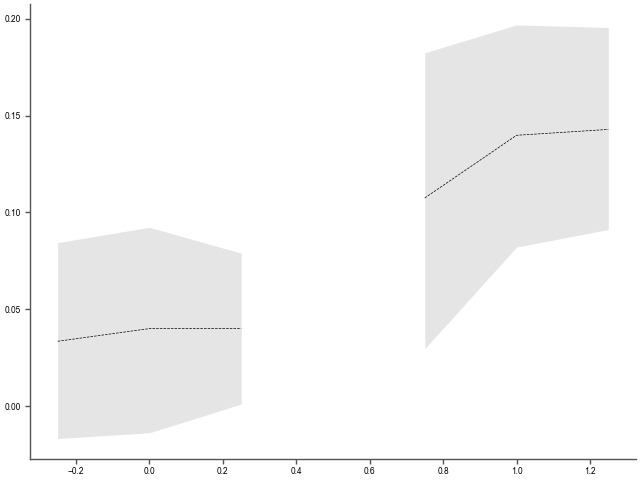

In [347]:
def add_shuf_CI(ax, comparison, group_desig):
    """Add confidence intervals (95%) from shuffled data to plots for mean correlation value - for PF2d only"""
    groups = [err.learners, err.ani_mice_good, err.nonlearners]
    x_offset = np.array([-0.25, 0, 0.25]) # amount seaborn offets data with dodge=True
    
    for ida, arena in enumerate(['Neutral', 'Shock']):
        # Get CIs
        CI_comb = []
        for group in groups:
            comp_shuf_CI = get_CI_mean(group, 'Open' if arena == 'Neutral' else arena, 
                                       comparison, group_desig)  # Get shuffled CI for all mice in group
            if comp_shuf_CI.ndim == 3:  # Reshape if more than one set of day-pairs in comparison
                comp_shuf_CI = comp_shuf_CI.swapaxes(0,1).reshape(3,-1).T
            CI_comb.append(np.nanmean(comp_shuf_CI, axis=0))  # Average it, add it into grou
        CI_plot = np.stack(CI_comb)  # make into array
        
        # Add to plot
        hl = ax.plot(x_offset + ida, CI_plot.T[1], color='k', linestyle='--', linewidth=0.5)
        ax.fill_between(x_offset + ida, CI_plot.T[0], CI_plot.T[2], color=[0, 0, 0, 0.1], linewidth=0)

    return CI_plot
_, ax = plt.subplots()
CI_plot = add_shuf_CI(ax, "After", 4)

In [106]:
def calc_PV1d_CI_from_mean_corrs(mean_shuf_corrs):
    """Calculates mean CI across all mice in a group. 
    Input = nmice x ndays x ndays x nshuffles arrray of mean shuffled values"""
    mean_CI = np.array([np.insert(np.quantile(_, (0.025, 0.975), axis=2), 1, 
                                  np.mean(_, axis=2)[None, :, :], axis=0) for _ in mean_shuf_corrs]).mean(axis=0)
    return mean_CI

In [329]:
def add_PV1shuf_CI(ax, learn_shuf_all, nl_shuf_all, ani_shuf_all, comparison, group_desig):
    """Add shuffled CIs to PV1d plots"""
    x_offset = np.array([-0.25, 0, 0.25])

    # ID appropriate session-pair(s)
    group_mat, group_labels = pfs.get_time_epochs(2, group_desig)
    comp_id = np.where([label == comparison for label in group_labels])[0] + 1
    keep_bool = group_mat[0] == comp_id

    for ida, arena in enumerate(['Neutral', 'Shock']):
        CI_comb = []
        for shuf_corrs in [l_shuf_all[ida], nl_shuf_all[ida], ani_shuf_all[ida]]:  # Grab corrs for that arena only
            mean_CI_shuf = calc_PV1d_CI_from_mean_corrs(shuf_corrs)
            CI_comb.append(mean_CI_shuf[:, keep_bool])
        CI_plot = np.array(CI_comb).squeeze()
        if CI_plot.ndim == 3:  # Take mean again if more than 1 session-pair
            CI_plot = CI_plot.mean(axis=2)
        hl = ax.plot(x_offset + ida, CI_plot, linestyle='--', color=[0, 0, 0, 0.5], linewidth=1)
        hl[1].set_linestyle('-')

# Test code - uncomment to check function working properly
# _, ax = plt.subplots()
# add_PV1shuf_CI(ax, l_shuf_all, nl_shuf_all, ani_shuf_all, 'Before v After(Days1-2)', 2)

### 2G-J and S4A-B: PF correlations plots

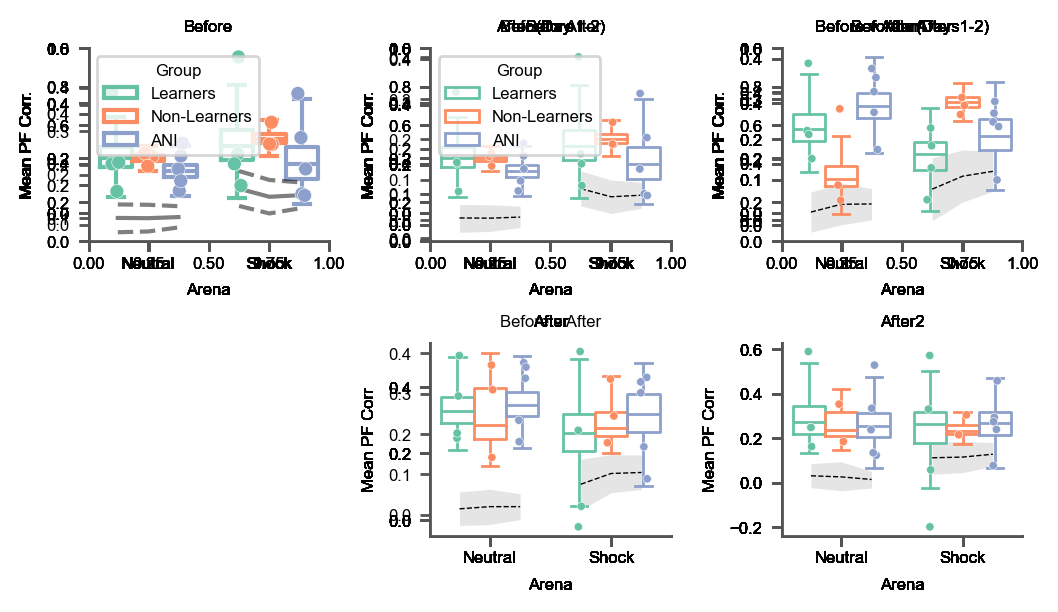

In [350]:
ax_bef_comb = Fig2comb.subplot([Fig2.gs[2, 2], Fig2stats.gs[2, 2]])
ax_ba_comb = Fig2comb.subplot([Fig2.gs[2, 3], Fig2stats.gs[2, 3]])
ax_aft_comb = Fig2comb.subplot([Fig2.gs[3, 2], Fig2stats.gs[3, 2]])
ax_aft2_comb = Fig2comb.subplot([Fig2.gs[3, 3], Fig2stats.gs[3, 3]])
ax_bstm_comb = FigS4comb.subplot(445)
ax_stma_comb = FigS4comb.subplot(446)

# Set up plotting params
ax_lims = [-0.1, 0.6]

for varname, epoch_name, a in zip(["before", "before_after", "after", "after2", "before_stm", "stm_after"], 
                                  ["Before", "Before v After", "After", "After2", "Before v STM", "STM v After"],
                                  [ax_bef_comb, ax_ba_comb, ax_aft_comb, ax_aft2_comb, ax_bstm_comb, ax_stma_comb]):

    # Load in variables and make things look nice
    corr_df = load_df(f"group_pf_corrs_{varname}")
    boot_df = load_df(f"group_pf_corrs_{varname}_bootstrap")

    # Make things pd.Categorical so they plot in a consistent order
    boot_df["Group"] = pd.Categorical(boot_df["Group"], ["Learners", "Non-Learners", "ANI"])
    boot_df["Arena"] = pd.Categorical(boot_df["Arena"], ["Neutral", "Shock"])

    # Take mean and also make pd.Categorical
    corr_means = corr_df.drop(columns=["session_pair", "day1", "arena2", "day2", "pair_no"]).groupby(["Group", "Arena", "mouse"]).apply(np.nanmean).reset_index()
    corr_means = corr_means.rename(columns={0: "corrs_sm"})
    corr_means["Group"] = pd.Categorical(corr_means["Group"], ["Learners", "Non-Learners", "ANI"])
    corr_means["Arena"] = pd.Categorical(corr_means["Arena"], ["Neutral", "Shock"])

    # Plot and add confidence intervals on shuffled data
    pfplot_compare3(boot_df, corr_df, epoch_name, ax=a[0])
    add_shuf_CI(a[0], epoch_name, 4)

    # Now calc and add stats
    pfcorr_bootstrap_stats(boot_df, epoch_name, a[1], col_use="Mean PF Corr", mult_compare=3)

Fig2.fig

### Figure S5: PV Correlation plots

In [368]:
boot_df

,Group,Arena,Comparison,Mean 1d PV Corr (Both),Mean 1d PV Corr (All)
0,Learners,Shock,STM v After,0.493077,-0.071780
1,Learners,Shock,STM v After,0.497614,-0.055564
2,Learners,Shock,STM v After,0.513240,0.014729
3,Learners,Shock,STM v After,0.514408,-0.098960
4,Learners,Shock,STM v After,0.552070,-0.056406
...,...,...,...,...,...
5995,ANI,Neutral,STM v After,0.452493,-0.318271
5996,ANI,Neutral,STM v After,0.465507,-0.370738
5997,ANI,Neutral,STM v After,0.560480,-0.373358
5998,ANI,Neutral,STM v After,0.484157,-0.376852


In [370]:
corr_df

,Group,Arena,Comparison,1d PV Corr (Both),1d PV Corr (All)
0,Learners,Shock,STM v After,0.553988,0.057855
1,Learners,Shock,STM v After,0.606330,-0.076702
2,Learners,Shock,STM v After,0.415366,-0.286517
3,Learners,Shock,STM v After,0.436117,0.002373
4,Non-Learners,Shock,STM v After,0.562528,-0.098866
5,Non-Learners,Shock,STM v After,0.402796,0.011184
6,Non-Learners,Shock,STM v After,0.637877,0.212513
7,ANI,Shock,STM v After,0.545870,-0.481185
8,ANI,Shock,STM v After,0.225289,-0.421473
9,ANI,Shock,STM v After,0.564332,-0.308150


In [401]:
groups = ['Learners', 'Non-Learners', 'ANI']
b = ['ANI', 'Learners', 'Non-Learners']
[idg if gname == 

ValueError: Cannot specify order when the array has no fields.

In [418]:
def group_sort_func(gname, sort_order = ['Learners', 'Non-Learners', 'ANI']):

    ind = None
    for idg, g in enumerate(sort_order):
        if g == gname:
            ind = idg
            
    return ind
group_sort_func('Non-Learner')

In [412]:
sort_order = ['Learners', 'Non-Learners', 'ANI']
gname = 'Learners'
[idg if (g == gname) else "" for idg, g in enumerate(sort_order)]

[0, '', '']

In [422]:
arena = 'Shock'
comp_type = 'Both'
group_order=['Learners', 'Non-Learners', 'ANI']
key_name = f"Shuf 1d PV Corr ({comp_type})"
quant_df['Group'] = pd.Categorical(quant_df.Group, group_order)
quant_df[(quant_df["quantile"] == 0.25) & (quant_df.Arena == arena)].sort_values(by='Group')

,Group,Arena,quantile,Mean 1d PV Corr (Both),Mean 1d PV Corr (All),Shuf 1d PV Corr (Both),Shuf 1d PV Corr (All)
6,Learners,Shock,0.25,0.423686,-0.390539,-0.050652,-0.421203
10,Non-Learners,Shock,0.25,0.379103,-0.207076,-0.038506,-0.258581
2,ANI,Shock,0.25,0.236674,-0.519616,-0.057576,-0.531052


In [427]:
mean_df[mean_df.Arena == arena].sort_values(by='Group')

,Group,Arena,Mean 1d PV Corr (Both),Mean 1d PV Corr (All),Shuf 1d PV Corr (Both),Shuf 1d PV Corr (All)
1,ANI,Shock,0.270885,-0.508037,-0.007004,-0.520048
3,Learners,Shock,0.454233,-0.377176,0.003862,-0.409617
5,Non-Learners,Shock,0.403410,-0.192340,-0.002021,-0.244642


In [433]:
quant_df

,Group,Arena,quantile,Mean 1d PV Corr (Both),Mean 1d PV Corr (All),Shuf 1d PV Corr (Both),Shuf 1d PV Corr (All)
0,ANI,Neutral,0.025,0.291712,-0.476143,-0.134088,-0.493033
1,ANI,Neutral,0.950,0.435231,-0.412099,0.115887,-0.433515
2,ANI,Shock,0.025,0.163283,-0.541390,-0.154756,-0.550371
3,ANI,Shock,0.950,0.355658,-0.479074,0.116254,-0.494106
4,Learners,Neutral,0.025,0.440801,-0.301367,-0.107407,-0.347247
5,Learners,Neutral,0.950,0.566128,-0.228355,0.101929,-0.281240
6,Learners,Shock,0.025,0.357272,-0.414010,-0.160696,-0.444159
7,Learners,Shock,0.950,0.528104,-0.346184,0.135238,-0.379646
8,Non-Learners,Neutral,0.025,0.403636,-0.204032,-0.102374,-0.256695
9,Non-Learners,Neutral,0.950,0.513832,-0.132987,0.094210,-0.186867


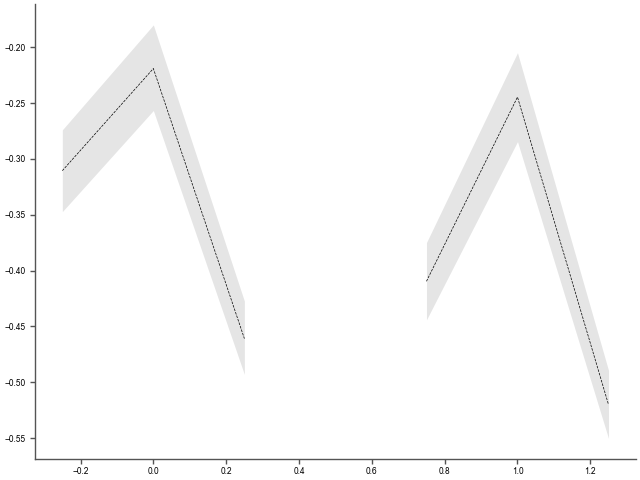

In [451]:
def add_shuf_PV_CI(ax, boot_df, pv_type: str in ['Both', 'All'], group_order=['Learners', 'Non-Learners', 'ANI']):
    """Add confidence intervals (95%) from shuffled data to plots for PV correlations"""

    key_name = f"Shuf 1d PV Corr ({pv_type})"
    x_offset = np.array([-0.25, 0, 0.25]) # amount seaborn offets data with dodge=True

    quant_df = boot_df.groupby(['Group', 'Arena']).quantile((0.025, 0.975), numeric_only=True).reset_index().rename(columns={'level_2' : 'quantile'})
    quant_df['Group'] = pd.Categorical(quant_df.Group, group_order)
    mean_df = boot_df.groupby(['Group', 'Arena']).mean(numeric_only=True).reset_index()
    mean_df['Group'] = pd.Categorical(mean_df.Group, group_order)
    
    for ida, arena in enumerate(['Neutral', 'Shock']):
        # Get CIs
        CI = []
        for quant in [0.025, 0.975]:
            CI.append(quant_df[(quant_df["quantile"] == quant) & (quant_df.Arena == arena)].sort_values(by='Group')[key_name].values)
        CI = np.array(CI)

        # Get mean
        mean_values = mean_df[mean_df.Arena == arena].sort_values(by='Group')[key_name].values
        
        # Add to plot
        ax.plot(x_offset + ida, mean_values, color='k', linestyle='--', linewidth=0.5)
        ax.fill_between(x_offset + ida, CI[0], CI[1], color=[0, 0, 0, 0.1], linewidth=0)

    return CI
_, ax = plt.subplots()
CI_plot = add_shuf_PV_CI(ax, boot_df, pv_type='All')

In [434]:
boot_df = load_df(f"group_pv1d_corrs_after2_bootstrap")
quant_df = boot_df.groupby(['Group', 'Arena']).quantile((0.025, 0.975), numeric_only=True).reset_index().rename(columns={'level_2' : 'quantile'})
mean_df = boot_df.groupby(['Group', 'Arena']).mean(numeric_only=True).reset_index()
mean_df

,Group,Arena,Mean 1d PV Corr (Both),Mean 1d PV Corr (All),Shuf 1d PV Corr (Both),Shuf 1d PV Corr (All)
0,ANI,Neutral,0.371433,-0.441392,0.003321,-0.460904
1,ANI,Shock,0.270885,-0.508037,-0.007004,-0.520048
2,Learners,Neutral,0.509762,-0.262843,0.005199,-0.310586
3,Learners,Shock,0.454233,-0.377176,0.003862,-0.409617
4,Non-Learners,Neutral,0.464017,-0.165192,0.002845,-0.219116
5,Non-Learners,Shock,0.403410,-0.192340,-0.002021,-0.244642


In [385]:
quant_df

,Group,Arena,quantile,Mean 1d PV Corr (Both),Mean 1d PV Corr (All),Shuf 1d PV Corr (Both),Shuf 1d PV Corr (All)
0,ANI,Neutral,0.25,0.341985,-0.453029,-0.042870,-0.472503
1,ANI,Neutral,0.95,0.435231,-0.412099,0.115887,-0.433515
2,ANI,Shock,0.25,0.236674,-0.519616,-0.057576,-0.531052
3,ANI,Shock,0.95,0.355658,-0.479074,0.116254,-0.494106
4,Learners,Neutral,0.25,0.484749,-0.277943,-0.035667,-0.323161
5,Learners,Neutral,0.95,0.566128,-0.228355,0.101929,-0.281240
6,Learners,Shock,0.25,0.423686,-0.390539,-0.050652,-0.421203
7,Learners,Shock,0.95,0.528104,-0.346184,0.135238,-0.379646
8,Non-Learners,Neutral,0.25,0.443307,-0.178934,-0.032328,-0.232036
9,Non-Learners,Neutral,0.95,0.513832,-0.132987,0.094210,-0.186867


/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_26255/1985804033.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quant_df = boot_df.groupby(['Group', 'Arena']).quantile((0.025, 0.975), numeric_only=True).reset_index().rename(columns={'level_2' : 'quantile'})
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_26255/1985804033.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = boot_df.groupby(['Group', 'Arena']).mean(numeric_only=True).reset_index()
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_26255/1985804033.py:7: FutureWarning: The default of observed=False is 

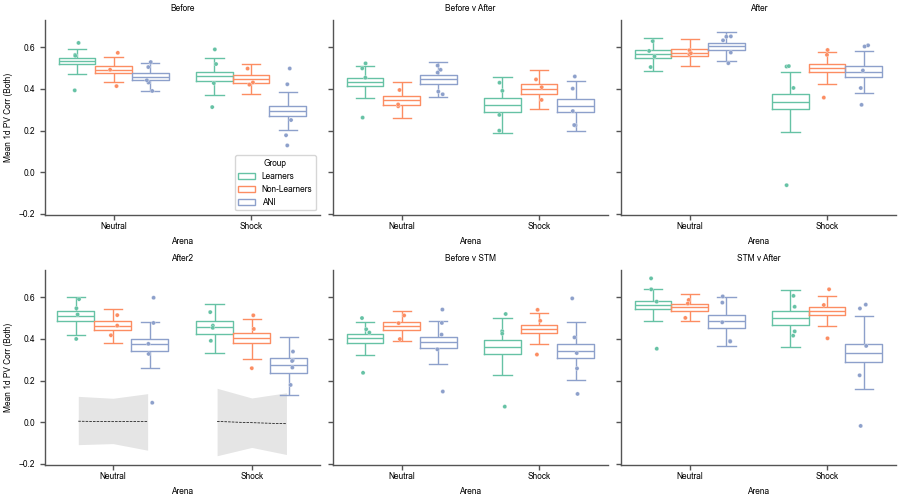

In [454]:
# Set up plotting params
pv_type = 'Both'
# ax_lims = [-0.1, 0.6]
_, ax = plt.subplots(2, 3, figsize=(9, 5), sharey=True)

for varname, epoch_name, a in zip(["before", "before_after", "after", "after2", "before_stm", "stm_after"], 
                                  ["Before", "Before v After", "After", "After2", "Before v STM", "STM v After"],
                                  ax.reshape(-1)):

    # Load in variables and make things look nice
    # group_pv1d_corrs_stm_after
    corr_df = load_df(f"group_pv1d_corrs_{varname}")
    boot_df = load_df(f"group_pv1d_corrs_{varname}_bootstrap")

    # Make things pd.Categorical so they plot in a consistent order
    boot_df["Group"] = pd.Categorical(boot_df["Group"], ["Learners", "Non-Learners", "ANI"])
    boot_df["Arena"] = pd.Categorical(boot_df["Arena"], ["Neutral", "Shock"])
    corr_df["Group"] = pd.Categorical(corr_df["Group"], ["Learners", "Non-Learners", "ANI"])
    corr_df["Arena"] = pd.Categorical(corr_df["Arena"], ["Neutral", "Shock"])

    # Plot and add confidence intervals on shuffled data
    pfplot_compare3(boot_df, corr_df, epoch_name, yboot=f"Mean 1d PV Corr ({pv_type})", yind=f"1d PV Corr ({pv_type})", ax=a)

    try:
        add_shuf_PV_CI(a, boot_df, pv_type)
    except KeyError:
        pass

    # # Now calc and add stats
    # pfcorr_bootstrap_stats(boot_df, epoch_name, a[1], col_use="Mean PF Corr", mult_compare=3)

#### Original submission plots with traditional statistics below

Missing pf files for Marble06 Open Day -2 to Open Day 7
Missing pf files for Marble06 Open Day -1 to Open Day 7
Missing pf files for Marble06 Open Day 4 to Open Day 7
Missing pf files for Marble06 Open Day 1 to Open Day 7
Missing pf files for Marble06 Open Day 2 to Open Day 7
Missing pf files for Marble06 Shock Day -2 to Shock Day 7
Missing pf files for Marble06 Shock Day -1 to Shock Day 7
Missing pf files for Marble06 Shock Day 4 to Shock Day 7
Missing pf files for Marble06 Shock Day 1 to Shock Day 7
Missing pf files for Marble06 Shock Day 2 to Shock Day 7


/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/pingouin/pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stats["Time"].fillna("-", inplace=True)
/Users/nkinsky/mambaforge/envs/eraser/lib/python3.9/site-packages/pingouin/pairwise.py:593: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

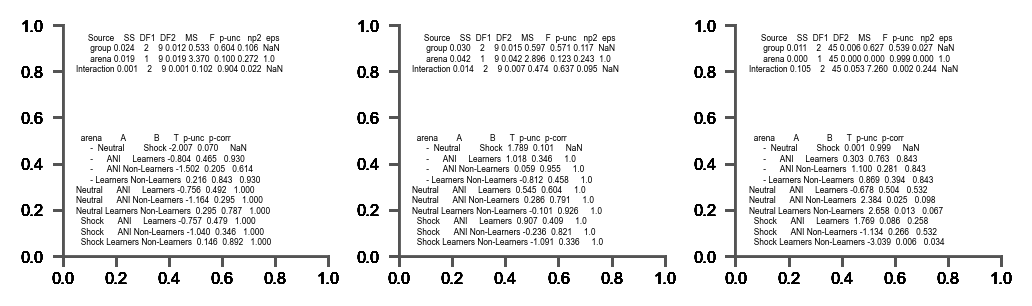

In [227]:
# Assemble dataframe
take_mean = False
learn_corr_all, nl_corr_all, ani_corr_all = assemble_mean_corrs_all(corr_type='PF', best_rot=True, 
                                                                    group_desig=group_desig, plot=False)
corr_df = mean_corrs_to_df(learn_corr_all, nl_corr_all, ani_corr_all, group_desig=group_desig)

# Set up plots for Fig2 and FigS4
ax_bef_comb = Fig2comb.subplot([Fig2.gs[2, 1], Fig2stats.gs[2, 1]])
ax_aft_comb = Fig2comb.subplot([Fig2.gs[2, 2], Fig2stats.gs[2, 2]])
ax_ba_comb = Fig2comb.subplot([Fig2.gs[2, 3], Fig2stats.gs[2, 3]])
ax_bstm_comb = FigS4comb.subplot(445)
ax_stma_comb = FigS4comb.subplot(446)

# Set up plotting params
ax_lims = [-0.1, 0.6]
anova_type = 'mixed'
within_first = True
padjust = 'holm'

# Now make the plots
for a, comp_type in zip([ax_bef_comb, ax_aft_comb, ax_ba_comb, ax_bstm_comb, ax_stma_comb], 
                        corr_df['comp_type'].unique()):
    legend_keep = True if comp_type in ['Before', 'Before v STM'] else False
    pfplot_compare2(corr_df, comp_type, a, ax_lims=ax_lims, anova_type=anova_type, within_first=within_first,
                   legend_keep=legend_keep, take_mean=take_mean, padjust=padjust, fontdict={"size": 3})
    add_shuf_CI(a[0], comp_type, group_desig)

Fig2stats.fig

Plot #11: compare before to after to examine stability change due to shock

Plot #9-10: same thing but combining all mice - plot ecdfs at various time points to look at remapping.

In [ ]:
# Define axes to plot into

# Main fig
gs_corr_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1, 1], grid=(1,2))
ax_all_bef_comb = [[Fig2.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2stats.subplot(446)]
gs_corr_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1, 2], grid=(1,2))
ax_all_aft_comb = [[Fig2.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2stats.subplot(447)]
gs_corr_subfig = Fig2.subplot2grid(subplot_spec=Fig2.gs[1, 3], grid=(1,2))
ax_all_ba_comb = [[Fig2.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2stats.subplot(448)]

# Supplemental Fig
gs_corr_subfig = FigS4.subplot2grid(subplot_spec=FigS4.gs[0, 0], grid=(1,2))
ax_all_bstm_comb = [[FigS4.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS4stats.subplot(441)]
gs_corr_subfig = FigS4.subplot2grid(subplot_spec=FigS4.gs[0, 1], grid=(1,2))
ax_all_stma_comb = [[FigS4.fig.add_subplot(gs) for gs in gs_corr_subfig], FigS4stats.subplot(442)]

ax_allpf_comb = [ax_all_bef_comb, ax_all_aft_comb, ax_all_ba_comb, ax_all_bstm_comb, ax_all_stma_comb]

In [ ]:
Fig2inset = Fig(num="Figure 2 Inset", grid=(2, 3), size=(6.5, 2*2 ), fontsize=6)
Fig2inset_stats = Fig(num="Figure 2 Inset stats", grid=(2, 3), size=(8.5, 2.5*3 ), fontsize=6)
Fig2insetcomb = FigMirror(Fig2inset, Fig2inset_stats)

# Main fig
gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[0, 0], grid=(1,2))
ax_all_bef_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(231)]
gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[0, 1], grid=(1,2))
ax_all_aft_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(232)]
gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[0, 2], grid=(1,2))
ax_all_ba_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(233)]

gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[1, 0], grid=(1,2))
ax_all_bstm_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(234)]
gs_corr_subfig = Fig2inset.subplot2grid(subplot_spec=Fig2inset.gs[1, 1], grid=(1,2))
ax_all_stma_comb_i = [[Fig2inset.fig.add_subplot(gs) for gs in gs_corr_subfig], Fig2inset_stats.subplot(235)]

ax_allpf_comb_i = [ax_all_bef_comb_i, ax_all_aft_comb_i, ax_all_ba_comb_i, ax_all_bstm_comb_i, ax_all_stma_comb_i]

In [ ]:
# Function here to add in stats to ecdf group
def add_ks_stats_to_ecdf(group_corrs, ax_use, ytext_start=0.8, bonf_corr=3, **kwargs):
    id1, id2 = [0, 0, 1], [1, 2, 2]
    group_names = ['Learners', 'Non-Learners', 'ANI']
    y = ytext_start
    for i1, i2 in zip(id1, id2):
        kstat, pval = sstats.ks_2samp(group_corrs[i1], group_corrs[i2])
        ax_use.text(0.1, y, f'{group_names[i1]} v {group_names[i2]}: pval={pval*bonf_corr:0.3g}, kstat={kstat:0.3g}',
                   **kwargs)
        y -= 0.1

In [ ]:
# Assemble and plot ecdfs
groups = [err.learners, err.nonlearners, err.ani_mice_good]
group_names = ['Learners', 'Non-Learners', 'ANI']
days = np.array([-2, -1, 4, 1, 2, 7])
best_rot = True
bonferroni_correction = 3 # multiply by this for bonferroni correction for multiple comparisons

epochs, group_labels = pfs.get_time_epochs(2, group_desig=group_desig)

rot_append = ': Best Rotation' if best_rot else ''
all_corrs = []
for ax, axin, comp in zip(ax_allpf_comb, ax_allpf_comb_i, group_labels):
    ax[0][0].set_title(comp + rot_append)
    comp_id = np.where([comp == group for group in group_labels])[0][0] + 1
    arena_corrs = []
    for ida, (a, ain, arena) in enumerate(zip(ax[0], axin[0], ['Open', 'Shock'])):

        # Aggregate corrs for arena
        days1, days2 = [days[id] for id in np.where(epochs[0] == comp_id)]
        group_corrs = []
        for group in groups:
            mouse_corrs = []
            for mouse in group:
                for day1, day2 in zip(days1, days2):
                    # Rotate pf maps to best rotation if specified
                    if best_rot:
                        _, rot_use, _ = pfs.get_best_rot(mouse, arena, int(day1), arena, int(day2), 
                                                         batch_map_use=True, print_to_screen=False)
                        rot = rot_use[1]
                    else:
                        rot = 0
                    _, corrs_sm = pfs.pf_corr_bw_sesh(mouse, arena, int(day1), arena, int(day2), batch_map_use=True,
                                                     rot_deg=rot)
                mouse_corrs.extend(corrs_sm)
            group_corrs.append(mouse_corrs)

        # Plot for arena
        line_types = ['-', '--', ':']
        for idc, corrs in enumerate(group_corrs):
            sns.ecdfplot(data=corrs, ax=a, color=plt.get_cmap("Set2").colors[idc], linewidth=0.5, 
                         linestyle=line_types[idc])

        if arena == 'Open':
            a.legend(a.lines, ['Learners', 'Non-Learners', 'ANI'])
            arena_str = 'Neutral'
        elif arena == 'Shock':
            arena_str = 'Shock'
        a.set_title(arena_str)
        a.set_xlabel('PF corrs')
        
        # Stats
        ax[1].text(0.1, 1.0, comp)
        ystatloc = 0.9 if arena == 'Open' else 0.4
#         print(str(ystatloc))
        ax[1].text(0.1, ystatloc, f'{arena_str}: pvals w/bonf corr={bonferroni_correction}')
        add_ks_stats_to_ecdf(group_corrs, ax[1], 0.8 - (0.4 * ida), bonf_corr=bonferroni_correction,
                             fontdict={"size": 3})
        arena_corrs.append(group_corrs)
        
        # Plot out inset bar plots
        dfbar = pd.DataFrame({'Corrs': list(flatten(group_corrs)), 
                              'Group' : list(flatten([[group_name]*len(group_corr) for 
                                                      group_corr, group_name in zip(group_corrs, group_names)]))})
        sns.barplot(data=dfbar, y='Corrs', x='Group', ax=ain, errwidth=1.0, palette='Set2')
        ain.set_title(f'{arena_str}: {comp}')
        astats = pg.anova(data=dfbar, dv='Corrs', between='Group')
        axin[1].text(0.1, ystatloc + 0.1, f'{arena_str}: {comp}')
        axin[1].text(0.1, ystatloc, str(astats))
        tuk_stats = pg.pairwise_tukey(data=dfbar, dv='Corrs', between='Group')
        axin[1].text(0.1, ystatloc-0.3, str(tuk_stats))
        
        
    all_corrs.append(arena_corrs)


In [ ]:
# Sanity check plots to make sure colors are being applied properly - uncomment if needed
# _, ax2 = plt.subplots(1, 2)
# for corrs in group_corrs:
#     sns.ecdfplot(data=corrs, ax=ax2[1], palette='Set2', linewidth=0.5)

# ax2[1].legend(ax2[1].lines, ['Learners', 'Non-Learners', 'ANI'])

# sns.set_palette("Set2")
# sns.ecdfplot(data=group_corrs[0], ax=ax2[0], color=plt.get_cmap("Set2").colors[0], linewidth=0.5)

## test

### Plot PV1d corrs (both) here

In [ ]:
# Test code for plotting out combined data means
dfbar = pd.DataFrame({'Corrs': list(flatten(group_corrs)), 
                      'Group' : list(flatten([[group_name]*len(group_corr) for 
                                              group_corr, group_name in zip(group_corrs, group_names)]))})
fig, ax = plt.subplots(figsize=(2.0, 2.5))
sns.barplot(data=dfbar, y='Corrs', x='Group', ax=ax, errwidth=1.0, palette='Set2')
astats = pg.anova(data=dfbar, dv='Corrs', between='Group')
print(astats)
tuk_stats = pg.pairwise_tukey(data=dfbar, dv='Corrs', between='Group')
print(tuk_stats)

In [ ]:
FigS4b = Fig(num="Figure S4b", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4b.fig.get_size_inches())
FigS4bstats = Fig(num="Figure S4bstats", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4bstats.fig.get_size_inches())
FigS4bcomb = FigMirror(FigS4b, FigS4bstats)

In [ ]:
FigS4c = Fig(num="Figure S4c", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4c.fig.get_size_inches())
FigS4cstats = Fig(num="Figure S4cstats", grid=(4, 4), size=(7.2, 5.3), fontsize=6)
print(FigS4cstats.fig.get_size_inches())
FigS4ccomb = FigMirror(FigS4c, FigS4cstats)

In [ ]:
for figcomb, corr_type, ax_lims in zip((FigS4bcomb, FigS4ccomb), ['PV1dboth', 'PV1dall'], ([-0.4, 0.8], [-0.8, 0.4])):
    
    # Assemble dataframe
    corrs_tup = assemble_mean_corrs_all(corr_type=corr_type, best_rot=True, group_desig=group_desig, plot=False, nshuf=1000)
    learn_corr_all, nl_corr_all, ani_corr_all, l_shuf_all, nl_shuf_all, ani_shuf_all = corrs_tup
    corr_df = mean_corrs_to_df(learn_corr_all, nl_corr_all, ani_corr_all, group_desig=group_desig)

    # Now plot into S4b and S4c
    ax_bef_comb = figcomb.subplot(441)
    ax_aft_comb = figcomb.subplot(442)
    ax_ba_comb = figcomb.subplot(443)
    ax_bstm_comb = figcomb.subplot(444)
    ax_stma_comb = figcomb.subplot(445)

    anova_type = 'mixed'
    within_first = True

    for a, comp_type in zip([ax_bef_comb, ax_aft_comb, ax_ba_comb, ax_bstm_comb, ax_stma_comb], 
                            corr_df['comp_type'].unique()):
        legend_keep = True if comp_type == 'Before' else False
        pfplot_compare2(corr_df, comp_type, a, ax_lims=ax_lims, anova_type=anova_type, within_first=within_first,
                       legend_keep=legend_keep)
        add_PV1shuf_CI(a[0], l_shuf_all, nl_shuf_all, ani_shuf_all, comp_type, group_desig)
        
    figcomb.Fig1.fig.suptitle(corr_type)

In [ ]:
FigS4b.fig

In [ ]:
FigS4c.fig

### NRK todo: look at overall event rate across days, normalized to day -1 for each mouse. Compare between groups.

2) Plot overlap between arenas for ANI vs Ctrls across all days - 4 hr session could be super interesting for ANI.

#2) Plot delta ER for ANI neurons vs. Ctrl neurons from -1 to -4 to 1 in shock arena

In [ ]:
peak_mean_c, peak_mean_a = [], []
def assemble_mean_peak(mice, day1, day2, arena, group_type=None):
    mean_peak_all, days_all, arena_all, animal_id = [], [], [], []
    for idm, mouse in enumerate(mice):
        a, b = discr.get_matched_peak_heights(mouse, arena, day1, arena, day2)
        mean_peak_all.extend([a.mean(), b.mean()])
        days_all.extend([day1, day2])
        arena_all.extend([arena, arena])
        animal_id.extend([idm, idm])
    if group_type is None:
        return pd.DataFrame({'Day': days_all, 'Arena': arena_all, 'Animal': animal_id, 'Mean Peak Height': mean_peak_all})
    else:
        return pd.DataFrame({'Day': days_all, 'Arena': arena_all, 'Animal': animal_id, 'Group': [group_type]*len(days_all), 'Mean Peak Height': mean_peak_all})


In [ ]:
FigS4comb.Fig1.fig

In [ ]:
# Plot mean of transient peaks for each session before/after ANI admin.
# ax_anipeak_14, ax_anipeak_14stats = FigS4comb.subplot2grid(FigS4comb.Fig1.gs[2,0], grid=(1,2), return_axes=True)
# ax_anipeak_1n1, ax_anipeak_1n1stats = FigS4comb.subplot2grid(FigS4comb.Fig1.gs[2,1], grid=(1,2), return_axes=True)

# For some reason things are plotting weird into FigS4 directly, so here is a workaround
fig_anipeak, ax_anipeak = plt.subplots(2, 2, figsize=(8.5/4, 6.5/2))
fig_anipeak_stats, ax_anipeak_stats = plt.subplots(2, 2, figsize=(4.25, 6.5/2))
ax_anipeak_14, ax_anipeak_1n1 = ax_anipeak
ax_anipeak_14stats, ax_anipeak_1n1stats = ax_anipeak_stats
day_pairs = [[-1, 4], [-1, 1]]
for ax, axs, day_pair in zip([ax_anipeak_14, ax_anipeak_1n1], [ax_anipeak_14stats, ax_anipeak_1n1stats], day_pairs):
    df_ctrl = assemble_mean_peak(err.control_mice_good, day_pair[0], day_pair[1], 'Open', 'Control')
    df_ani = assemble_mean_peak(err.ani_mice_good, day_pair[0], day_pair[1], 'Open', 'ANI')
    ax[0].get_shared_y_axes().join(ax[0], ax[1])
    ax[1].set_yticklabels([])
    for ida, (a, df) in enumerate(zip(ax, [df_ctrl, df_ani])):
        g = sns.pointplot(data=df, x='Day', y='Mean Peak Height', hue='Animal', ax=a, scale=0.5,
                          palette=[plt.get_cmap('Set2').colors[ida*2]]*len(df['Animal'].unique()), legend=False)
        g.legend_.remove()
        a.set_title(df['Group'][0])
        sns.despine(ax=a)
        
        stats = pg.ttest(df[df['Day'] == day_pair[0]]['Mean Peak Height'], 
                      df[df['Day'] == day_pair[1]]['Mean Peak Height'])
        axs[0].set_title(f'Mean Peak height day {day_pair[0]} to day {day_pair[1]}')
        axs[0].text(0.1, 0.9 - ida * 0.5, f"{df['Group'][0]} t-test")
        axs[0].text(0.1, 0.6 - ida * 0.5, str(stats), fontdict={"size": 3})
        axs[1].axis('off')
        


In [ ]:
FigS4.fig

## Save all figures

In [ ]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
for comb_fig_save, name in zip([Fig2comb, FigS4comb, FigS4bcomb, FigS4ccomb, Fig2insetcomb], 
                               ['Figure2', 'FigureS4', 'FigureS4b_PV1dboth', 'FigureS4c_PV1dall', 'Figure2inset']):
    if comb_fig_save is not None:
        comb_fig_save.Fig1.savefig(plot_path / (name + '.pdf'), scriptname = 'Figure2_and_S4.ipynb')
        comb_fig_save.Fig2.savefig(plot_path / (name + '_stats.pdf'), scriptname = 'Figure2_and_S4.ipynb')

In [ ]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
Fig2insetcomb.Fig1.savefig(plot_path / 'Figure2inset.pdf', scriptname = 'Figure2_and_S4.ipynb')
Fig2insetcomb.Fig2.savefig(plot_path / 'Figure2inset_stats.pdf', scriptname = 'Figure2_and_S4.ipynb')
fig_anipeak.savefig(plot_path / 'FigureS4_transient_peaks.pdf')
fig_anipeak_stats.savefig(plot_path / 'FigureS4_transient_peaks_stats.pdf')